In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# EDA/Cleaning

It is important to demonstrate the nature of data, so that it is possible to then clean it. Then, do an exploratory analysis again, so that it is possible to see it again.

In [ ]:
df_prerequisites = pd.read_csv("data/uiuc-prerequisites.csv")

df_learning_analytics = pd.read_csv("data/assessments.csv")

# imports the database from the Internet. Apparently, this is the best(if not only) possible method 
# in HuggingFace
df_coursera = pd.read_csv("hf://datasets/azrai99/coursera-course-dataset/coursera_course_2024.csv")

## Initial EDA

### Prerequisites Dataset

In [3]:
df_prerequisites.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8589 entries, 0 to 8588
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Course              8589 non-null   object 
 1   PrerequisiteNumber  8589 non-null   int64  
 2   0                   3426 non-null   object 
 3   1                   1574 non-null   object 
 4   2                   673 non-null    object 
 5   3                   287 non-null    object 
 6   4                   111 non-null    object 
 7   5                   54 non-null     object 
 8   6                   36 non-null     object 
 9   7                   16 non-null     object 
 10  8                   1 non-null      object 
 11  9                   0 non-null      float64
dtypes: float64(1), int64(1), object(10)
memory usage: 805.3+ KB


In [4]:
df_prerequisites["Course"].value_counts(dropna=False)

Course
ZULU 406    1
AAS 100     1
AAS 105     1
AAS 120     1
AAS 199     1
           ..
AAS 283     1
AAS 286     1
AAS 287     1
AAS 288     1
AAS 290     1
Name: count, Length: 8589, dtype: int64

In [16]:
df_prerequisite_number_count = df_prerequisites["PrerequisiteNumber"].value_counts(dropna=False)

Text(0.5, 0, '# of prerequisites for course')

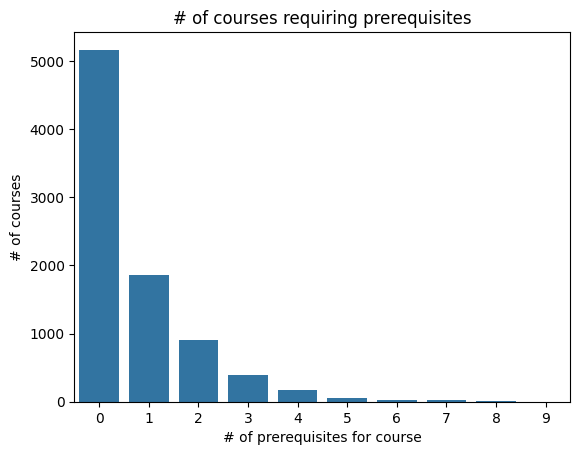

In [24]:
sns.barplot(data=df_prerequisite_number_count)
plt.title("# of courses requiring prerequisites")
plt.ylabel("# of courses")
plt.xlabel("# of prerequisites for course")

In [ ]:
df_prerequisites["8"].value_counts(dropna=False)

pandas.core.series.Series

In [13]:
df_prerequisites.head()

,Course,PrerequisiteNumber,0,1,2,3,4,5,6,7,8,9
0,AAS 100,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAS 105,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAS 120,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAS 199,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAS 200,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df_prerequisites[df_prerequisites["8"]=="ACES 299"]

,Course,PrerequisiteNumber,0,1,2,3,4,5,6,7,8,9
677,ANSC 498,9,ANSC 293,ANSC 294,ANSC 295,ANSC 299,ANSC 396,ANSC 398,ACES 293,ACES 298,ACES 299,NaN
